# Solution Exercise 8.1
### Classification of magnetic phases
Imagine a 2- dimensional lattice arrangement of n×n magnetic dipole moments (spins) that can be in one of two states (+1 or −1, Ising model).
With interactions between spins being short ranged, each spin interacts only with its four neighbors.
The probability to find a spin in one of the orientations is a function of temperature T according to p ∼ exp (−a/T ), a = const.).

At extremely low temperatures T → 0, neighboring spins have a very low probability of different orientations, so that a uniform overall state (ferromagnetic state) is adopted, characterized by +1 or −1.
At very high temperatures T → ∞, a paramagnetic phase with random spin alignment results, yielding 50% of +1 and  0% of −1 orientations.
Below a critical temperature 0 < T < Tc, stable ferromagnetic domains emerge, with both orientations being equally probable in the absence of an external magnetic field.
The spin-spin correlation function diverges at Tc, whereas the correlation decays for T > Tc.

The data for this task contain the n × n dipole orientations on the lattice for different temperatures T.
Classify the two magnetic phases (paramagnetic/ferromagnetic)!

In [2]:
from tensorflow import keras
import numpy as np
callbacks = keras.callbacks
layers = keras.layers

print("keras", keras.__version__)

keras 2.4.0


### Load and prepare dataset
See https://doi.org/10.1038/nphys4035 for more information

In [3]:
import gdown
url = "https://drive.google.com/u/0/uc?export=download&confirm=HgGH&id=1Ihxt1hb3Kyv0IrjHlsYb9x9QY7l7n2Sl"
output = 'ising_data.npz'
gdown.download(url, output, quiet=True)

f = np.load(output)
n_train = 20000

x_train, x_test = f["C"][:n_train], f["C"][n_train:]
T_train, T_test = f["T"][:n_train], f["T"][n_train:]

### Plot data

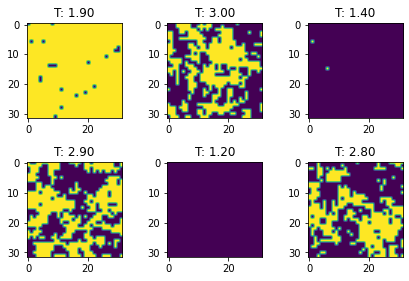

In [4]:
import matplotlib.pyplot as plt

for i,j in enumerate(np.random.choice(n_train, 6)):
    plt.subplot(2,3,i+1)
    image = x_train[j]
    plot = plt.imshow(image)
    plt.title("T: %.2f" % T_train[j])

plt.tight_layout()
plt.show()

Text(0, 0.5, 'frequency')

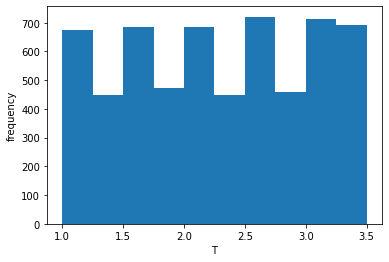

In [4]:
plt.hist(T_test)
plt.xlabel("T")
plt.ylabel("frequency")

#### Set up training data - define magnetic phases

In [5]:
Tc = 2.27
y_train, y_test = T_train > Tc, T_test > Tc

 ### Task

 - evaluate the test accuracy for a convolutional network,
 - plot the test accuracy vs. temperature.
 - compare to the results obtained using a fully-connected network (Exercise 7.1)

In [6]:
model = keras.models.Sequential()
model.add(layers.InputLayer(input_shape=(32, 32)))
model.add(layers.Reshape((32, 32,1)))
model.add(layers.Convolution2D(16, (3, 3), padding='same', activation='relu'))
model.add(layers.Convolution2D(16, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Convolution2D(32, (3, 3), padding='same', activation='relu'))
model.add(layers.Convolution2D(32, (3, 3), padding='same', activation='relu'))
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dropout(0.25))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 16)        2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0

### prepare model for training

In [7]:
model.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.Adam(0.001),
    metrics=['accuracy'])


In [8]:
history = model.fit(
    x_train, y_train,
    batch_size=32,
    epochs=50,
    verbose=2,
    validation_split=0.1,
    callbacks=[
        callbacks.EarlyStopping(patience=5, verbose=1),
        callbacks.ReduceLROnPlateau(factor=0.67, patience=2, verbose=1)]
)

Epoch 1/50
563/563 - 15s - loss: 0.0711 - accuracy: 0.9693 - val_loss: 0.0504 - val_accuracy: 0.9810
Epoch 2/50
563/563 - 13s - loss: 0.0483 - accuracy: 0.9800 - val_loss: 0.0499 - val_accuracy: 0.9745
Epoch 3/50
563/563 - 12s - loss: 0.0466 - accuracy: 0.9804 - val_loss: 0.0444 - val_accuracy: 0.9810
Epoch 4/50
563/563 - 12s - loss: 0.0476 - accuracy: 0.9804 - val_loss: 0.0416 - val_accuracy: 0.9840
Epoch 5/50
563/563 - 12s - loss: 0.0448 - accuracy: 0.9820 - val_loss: 0.0398 - val_accuracy: 0.9815
Epoch 6/50
563/563 - 13s - loss: 0.0438 - accuracy: 0.9817 - val_loss: 0.0463 - val_accuracy: 0.9795
Epoch 7/50
563/563 - 13s - loss: 0.0443 - accuracy: 0.9814 - val_loss: 0.0397 - val_accuracy: 0.9815

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0006700000318232924.
Epoch 8/50
563/563 - 14s - loss: 0.0411 - accuracy: 0.9835 - val_loss: 0.0392 - val_accuracy: 0.9845
Epoch 9/50
563/563 - 13s - loss: 0.0411 - accuracy: 0.9822 - val_loss: 0.0443 - val_accuracy: 0.9810
Epoch 10/5

### Evaluate training

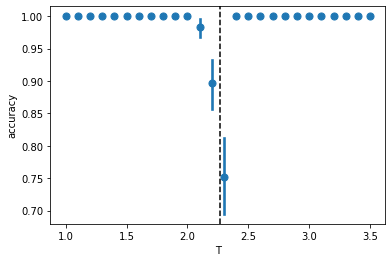

In [11]:
import seaborn as sns

preds = model.predict(x_test).round().squeeze()
acc = (preds == y_test).astype(np.float)

ax = sns.regplot(x=T_test, y=acc, x_estimator= np.mean, fit_reg=False)
ax.set_ylabel("accuracy")
ax.set_xlabel("T")
plt.axvline(x=Tc, color='k', linestyle='--', label='Tc')